<a href="https://colab.research.google.com/github/Krishna-Kant-Bharadwaj/animalclassification/blob/main/Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset is ready!
Training categories: ['Zebra', 'Elephant', 'Kangaroo', 'Giraffe', 'Lion', 'Tiger', 'Horse', 'Panda', 'Dog', 'Dolphin', 'Cat', 'Cow', 'Bird', 'Deer', 'Bear']
Labels: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]
Epoch 1/5: 100%|██████████| 43/43 [14:54<00:00, 20.81s/it]


Epoch 1: Train Loss = 1.3253, Val Accuracy = 0.9141


Epoch 2/5: 100%|██████████| 43/43 [14:45<00:00, 20.60s/it]


Epoch 2: Train Loss = 0.4516, Val Accuracy = 0.9416


Epoch 3/5: 100%|██████████| 43/43 [14:39<00:00, 20.46s/it]


Epoch 3: Train Loss = 0.3354, Val Accuracy = 0.9759


Epoch 4/5: 100%|██████████| 43/43 [14:40<00:00, 20.48s/it]


Epoch 4: Train Loss = 0.2938, Val Accuracy = 0.9622


Epoch 5/5: 100%|██████████| 43/43 [14:18<00:00, 19.96s/it]


Epoch 5: Train Loss = 0.2498, Val Accuracy = 0.9691
Training complete! Best Validation Accuracy = 0.9759450171821306
              precision    recall  f1-score   support

        Bear       0.95      0.95      0.95        19
        Bird       0.91      1.00      0.95        21
         Cat       1.00      0.95      0.97        19
         Cow       0.95      0.90      0.92        20
        Deer       0.86      0.95      0.90        20
         Dog       1.00      0.89      0.94        19
     Dolphin       1.00      1.00      1.00        20
    Elephant       1.00      0.95      0.97        20
     Giraffe       0.95      1.00      0.98        20
       Horse       1.00      0.95      0.97        20
    Kangaroo       0.85      0.89      0.87        19
        Lion       0.95      1.00      0.98        20
       Panda       1.00      0.95      0.98        21
       Tiger       1.00      1.00      1.00        20
       Zebra       1.00      1.00      1.00        21

    accuracy     

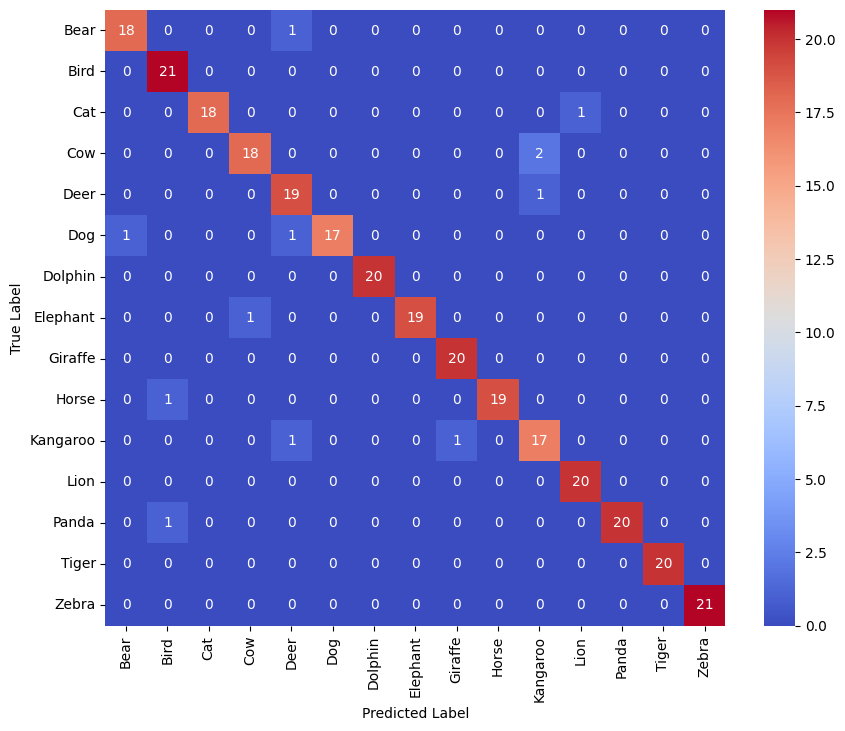

Sample image: /content/drive/My Drive/animal_classification/Animal Classification/dataset/test/Bear/Bear_12_1.jpg
Predicted: [('Bear', 0.9895673394203186), ('Panda', 0.003280520671978593), ('Dog', 0.000972122885286808)]


In [2]:
# ==============================
# STEP 0: ENVIRONMENT SETUP
# ==============================
!pip install torch torchvision scikit-learn matplotlib seaborn tqdm

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# ==============================
# STEP 1: DATASET HANDLING
# ==============================
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/My Drive/animal_classification/Animal Classification/dataset/"

train_path = os.path.join(BASE_DIR, "train")
val_path   = os.path.join(BASE_DIR, "val")
test_path  = os.path.join(BASE_DIR, "test")

if not os.path.exists(train_path):
    from sklearn.model_selection import train_test_split
    categories = [c for c in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, c))]

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for label in categories:
        img_dir = os.path.join(BASE_DIR, label)
        imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(('jpg','jpeg','png'))]

        train_files, temp = train_test_split(imgs, test_size=0.3, random_state=123)
        val_files, test_files = train_test_split(temp, test_size=0.5, random_state=123)

        for subset, subset_files in [("train", train_files), ("val", val_files), ("test", test_files)]:
            out_path = os.path.join(BASE_DIR, subset, label)
            os.makedirs(out_path, exist_ok=True)
            for f in subset_files:
                shutil.copy(f, os.path.join(out_path, os.path.basename(f)))

print("Dataset is ready!")
print("Training categories:", os.listdir(train_path))

# ==============================
# STEP 2: DATALOADERS
# ==============================
IMAGE_SIZE = 224
BATCH = 32

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
valtest_transforms = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.1)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_path, transform=valtest_transforms)
test_dataset  = datasets.ImageFolder(test_path, transform=valtest_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=2)

labels = train_dataset.classes
print("Labels:", labels)

# ==============================
# STEP 3: MODEL SETUP
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = models.resnet50(weights="IMAGENET1K_V1")
feat_dim = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(feat_dim, len(labels))
cnn_model = cnn_model.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-4)

# ==============================
# STEP 4: TRAINING PROCEDURE
# ==============================
def validate(model, loader):
    model.eval()
    true_labels, predictions = [], []
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1)
            true_labels.extend(targets.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    return np.array(true_labels), np.array(predictions)

EPOCHS = 5   # 🔹 increase for better results
best_acc = 0

for ep in range(EPOCHS):
    cnn_model.train()
    total_loss = 0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {ep+1}/{EPOCHS}"):
        imgs, targets = imgs.to(device), targets.to(device)
        opt.zero_grad()
        outputs = cnn_model(imgs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        opt.step()
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(train_dataset)
    y_val, y_val_pred = validate(cnn_model, val_loader)
    acc_val = (y_val == y_val_pred).mean()

    print(f"Epoch {ep+1}: Train Loss = {avg_loss:.4f}, Val Accuracy = {acc_val:.4f}")

    if acc_val > best_acc:
        best_acc = acc_val
        torch.save(cnn_model.state_dict(), "resnet_best.pth")

print("Training complete! Best Validation Accuracy =", best_acc)

# ==============================
# STEP 5: TESTING & REPORT
# ==============================
cnn_model.load_state_dict(torch.load("resnet_best.pth", map_location=device))

y_test, y_test_pred = validate(cnn_model, test_loader)
print(classification_report(y_test, y_test_pred, target_names=labels))

conf_mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================
# STEP 6: PREDICTION FUNCTION
# ==============================
from PIL import Image

def classify_image(path, k=3):
    image = Image.open(path).convert("RGB")
    tensor = valtest_transforms(image).unsqueeze(0).to(device)
    cnn_model.eval()
    with torch.no_grad():
        out = cnn_model(tensor)
        prob = torch.softmax(out, dim=1).cpu().numpy()[0]
        idxs = prob.argsort()[-k:][::-1]
        return [(labels[i], float(prob[i])) for i in idxs]

# 🔹 Example inference
test_sample = list(test_dataset.samples)[0][0]
print("Sample image:", test_sample)
print("Predicted:", classify_image(test_sample))
